In [1]:
import cirq
import numpy as np
import matplotlib.pyplot as plt
from qiskit_ibm_provider import IBMProvider
from qiskit import QuantumCircuit, transpile
from mitiq.zne.scaling import fold_gates_at_random
from mitiq.zne import inference
from collections import Counter

In [2]:
@cirq.transformer
class SubstituteGate:
    """Transformer to substitute `source` gates with `target` in the input circuit."""

    def __init__(self, source, target):
        self._source = source
        self._target = target

    def __call__(self, circuit, *, context=None):
        batch_replace = []
        for i, op in circuit.findall_operations(lambda op: op.gate == self._source):
            batch_replace.append((i, op, self._target.on(*op.qubits)))
        transformed_circuit = circuit.unfreeze(copy=True)
        transformed_circuit.batch_replace(batch_replace)
        return transformed_circuit

substitute_h_inv = SubstituteGate(cirq.H**-1.0,cirq.H)
substitute_cnot_inv = SubstituteGate(cirq.CNOT**-1.0,cirq.CNOT)

In [3]:
#RCNOT implements CNOT(control,target)
#with 4 Hadamards and CNOT(target,control)
def RCNOT(control,target):
    yield cirq.H(control)
    yield cirq.H(target)
    yield cirq.CNOT(target,control)
    yield cirq.H(control)
    yield cirq.H(target)

#Reminder: cirq.CNOT(control,target)
#Reference:
#https://quantumcomputing.stackexchange.com/questions/9623/constructing-a-circuit-for-c1u-for-rotation-operators-with-two-single-qubit
def cRy(theta,control,target,reverse=False):
    if reverse:
        yield from RCNOT(control,target)
    else:
        yield cirq.CNOT(control,target)
    yield cirq.Ry(rads=-theta/2).on(target)
    if reverse:
        yield from RCNOT(control,target)
    else:
        yield cirq.CNOT(control,target)
    yield cirq.Ry(rads=theta/2).on(target)

def zz_xx_pump(sys,env,p):
    yield cirq.CNOT(sys[1],sys[0])
    yield cirq.X(env[0])
    yield cirq.CNOT(sys[0],env[0])
    yield from cRy(2*np.arcsin(np.sqrt(p)),env[0],sys[0],reverse=True)
    yield cirq.CNOT(sys[0],env[0])
    yield cirq.H(sys[1])
    yield cirq.X(env[1])
    yield from RCNOT(sys[1],env[1])
    yield from cRy(2*np.arcsin(np.sqrt(p)),env[1],sys[1])
    yield from RCNOT(sys[1],env[1])

In [4]:
env = [cirq.LineQubit(0),cirq.LineQubit(3)]
sys = [cirq.LineQubit(1),cirq.LineQubit(2)]
probs = np.linspace(0,1,num=5)
repcnt = 1024

<hr></hr>

In [5]:
test_circuit = cirq.Circuit(zz_xx_pump(sys,env,1.0))
test_circuit.append(cirq.measure(sys, key = 'answer'))
print(test_circuit)

0: ───X───X───H───X───H───H───────────────────────X───H─────────────────────X─────────────────────
          │       │                               │                         │
1: ───X───@───H───@───H───Ry(-0.5π)───H───────────@───H──────────Ry(0.5π)───@───────M('answer')───
      │                                                                             │
2: ───@───H───H───X───H───X───────────Ry(-0.5π)───X───Ry(0.5π)───H──────────X───H───M─────────────
                  │       │                       │                         │
3: ───X───H───────@───H───@───────────────────────@───H─────────────────────@───H─────────────────


In [6]:
#Decomposition of Hadamard into OQC/IBM basis gates
q0 = cirq.LineQubit(0)
q1 = cirq.LineQubit(1)
had_circuit = cirq.Circuit([cirq.H(q0),cirq.H(q0)])
had_qiskit = QuantumCircuit.from_qasm_str(had_circuit.to_qasm())
had_t = transpile(had_qiskit,basis_gates=['rz','sx','x','ecr','id'],optimization_level=0)
print(had_qiskit)
print(had_t)

   ┌───┐┌───┐
q: ┤ H ├┤ H ├
   └───┘└───┘
global phase: π/2
   ┌─────────┐┌────┐┌─────────┐┌─────────┐┌────┐┌─────────┐
q: ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├
   └─────────┘└────┘└─────────┘└─────────┘└────┘└─────────┘


In [7]:
#Decomposition of CNOT into OQC/IBM basis gates
cnot_circuit = cirq.Circuit([cirq.CNOT(q0,q1),cirq.CNOT(q0,q1)])
cnot_qiskit = QuantumCircuit.from_qasm_str(cnot_circuit.to_qasm())
cnot_t = transpile(cnot_qiskit,basis_gates=['rz','sx','x','ecr','id'],optimization_level=0)
print(cnot_qiskit)
print(cnot_t)

               
q_0: ──■────■──
     ┌─┴─┐┌─┴─┐
q_1: ┤ X ├┤ X ├
     └───┘└───┘
global phase: π
     ┌──────────┐                                       ┌──────┐   ┌───┐   »
q_0: ┤ Rz(-π/2) ├───────────────────────────────────────┤0     ├───┤ X ├───»
     ├─────────┬┘┌─────────┐┌────┐┌─────────┐┌─────────┐│  Ecr │┌──┴───┴──┐»
q_1: ┤ Rz(π/2) ├─┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤1     ├┤ Rz(π/2) ├»
     └─────────┘ └─────────┘└────┘└─────────┘└─────────┘└──────┘└─────────┘»
«     ┌──────────┐                            ┌──────┐┌───┐
«q_0: ┤ Rz(-π/2) ├────────────────────────────┤0     ├┤ X ├
«     ├─────────┬┘┌────┐┌─────────┐┌─────────┐│  Ecr │└───┘
«q_1: ┤ Rz(π/2) ├─┤ √X ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤1     ├─────
«     └─────────┘ └────┘└─────────┘└─────────┘└──────┘     


In [8]:
#Decomposition of Ry into OQC/IBM basis gates
q0 = cirq.LineQubit(0)
ry_circuit = cirq.Circuit([cirq.Ry(rads=0.5).on(q0)])
ry_qiskit = QuantumCircuit.from_qasm_str(ry_circuit.to_qasm())
ry_t = transpile(ry_qiskit,basis_gates=['rz','sx','x','ecr','id'],optimization_level=0)
print(ry_qiskit)
print(ry_t)

   ┌─────────┐
q: ┤ Ry(0.5) ├
   └─────────┘
global phase: 3π/2
   ┌───────┐┌────┐┌────────────┐┌────┐┌────────┐
q: ┤ Rz(0) ├┤ √X ├┤ Rz(3.6416) ├┤ √X ├┤ Rz(3π) ├
   └───────┘└────┘└────────────┘└────┘└────────┘


In [9]:
#Decomposition of Rx into OQC/IBM basis gates
q0 = cirq.LineQubit(0)
rx_circuit = cirq.Circuit([cirq.Rx(rads=0.5).on(q0)])
rx_qiskit = QuantumCircuit.from_qasm_str(rx_circuit.to_qasm())
rx_t = transpile(rx_qiskit,basis_gates=['rz','sx','x','ecr','id'],optimization_level=0)
print(rx_qiskit)
print(rx_t)

   ┌─────────┐
q: ┤ Rx(0.5) ├
   └─────────┘
global phase: 3π/2
   ┌─────────┐┌────┐┌────────────┐┌────┐┌──────────┐
q: ┤ Rz(π/2) ├┤ √X ├┤ Rz(3.6416) ├┤ √X ├┤ Rz(5π/2) ├
   └─────────┘└────┘└────────────┘└────┘└──────────┘


In [10]:
#Decomposition of X into OQC/IBM basis gates
q0 = cirq.LineQubit(0)
q1 = cirq.LineQubit(1)
cry_circuit = cirq.Circuit(cRy(0.5,q1,q0))
cry_qiskit = QuantumCircuit.from_qasm_str(cry_circuit.to_qasm())
cry_t = transpile(cry_qiskit,basis_gates=['rz','sx','x','ecr','id'],optimization_level=0)
print(cry_t.depth())
print(cry_qiskit)
print(cry_t)

22
     ┌───┐┌───────────┐┌───┐┌──────────┐
q_0: ┤ X ├┤ Ry(-0.25) ├┤ X ├┤ Ry(0.25) ├
     └─┬─┘└───────────┘└─┬─┘└──────────┘
q_1: ──■─────────────────■──────────────
                                        
     ┌─────────┐ ┌─────────┐┌────┐┌─────────┐┌─────────┐┌──────┐┌───────┐»
q_0: ┤ Rz(π/2) ├─┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤1     ├┤ Rz(0) ├»
     ├─────────┴┐└─────────┘└────┘└─────────┘└─────────┘│  Ecr │└─┬───┬─┘»
q_1: ┤ Rz(-π/2) ├───────────────────────────────────────┤0     ├──┤ X ├──»
     └──────────┘                                       └──────┘  └───┘  »
«        ┌────┐   ┌────────────┐┌────┐┌────────┐┌─────────┐┌─────────┐┌────┐»
«q_0: ───┤ √X ├───┤ Rz(2.8916) ├┤ √X ├┤ Rz(3π) ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ √X ├»
«     ┌──┴────┴──┐└────────────┘└────┘└────────┘└─────────┘└─────────┘└────┘»
«q_1: ┤ Rz(-π/2) ├──────────────────────────────────────────────────────────»
«     └──────────┘                                                          »
«     ┌─────────┐┌─────────

<hr></hr>

In [62]:
provider = IBMProvider()
backend = provider.get_backend('ibm_osaka')

In [208]:
print(backend.max_circuits)

300


In [ ]:
#Run this cell to get a view of the qubit layout
import networkx as nx
G=nx.DiGraph(list(backend.coupling_map))
plt.figure(1,figsize=(12,8)) 
nx.draw_networkx(G,pos=nx.planar_layout(G),node_size=60,font_size=8)
plt.show()

In [5]:
test_circuit = cirq.Circuit(zz_xx_pump(sys,env,1.0))
test_circuit.append(cirq.measure(sys, key = 'answer'))
print(test_circuit)

0: ───X───X───H───X───H───H───────────────────────X───H─────────────────────X─────────────────────
          │       │                               │                         │
1: ───X───@───H───@───H───Ry(-0.5π)───H───────────@───H──────────Ry(0.5π)───@───────M('answer')───
      │                                                                             │
2: ───@───H───H───X───H───X───────────Ry(-0.5π)───X───Ry(0.5π)───H──────────X───H───M─────────────
                  │       │                       │                         │
3: ───X───H───────@───H───@───────────────────────@───H─────────────────────@───H─────────────────


In [73]:
initial_layout = [64,63,62,72]
initial_layout.reverse()
print(initial_layout)

[72, 62, 63, 64]


In [17]:
scale_factors = [1,3,5,7]

In [74]:
circ_list = []
for scale_factor in scale_factors:
    for p in probs:
        for j in range(2**2):
            circuit = cirq.Circuit()
            if (j&1) == 1:
                circuit.append(cirq.X.on(sys[0]))
            if (j&2) == 2:
                circuit.append(cirq.X.on(sys[1]))
            circuit.append(zz_xx_pump(sys,env,p))
            circuit_folded = fold_gates_at_random(circuit,scale_factor)
            circuit_transformed = substitute_cnot_inv(substitute_h_inv(circuit_folded))
            circuit_transformed.append(cirq.measure(sys, key = 'answer'))
            circuit_qiskit = QuantumCircuit.from_qasm_str(circuit_transformed.to_qasm())
            transpiled_circuit = transpile(circuit_qiskit,backend=backend,optimization_level=0,initial_layout=initial_layout)
            circ_list.append(transpiled_circuit)

<h2>Circuit depth scaling plot:</h2>

In [75]:
from scipy.stats import linregress
from scipy.optimize import curve_fit
def cfit(x,a,b):
    return a*x+b
circ_depth_sca = []
for scale_factor in scale_factors:
    circuit = cirq.Circuit(zz_xx_pump(sys,env,p))
    circuit_folded = fold_gates_at_random(circuit,scale_factor)
    circuit_transformed = substitute_cnot_inv(substitute_h_inv(circuit_folded))
    circuit_qiskit = QuantumCircuit.from_qasm_str(circuit_transformed.to_qasm())
    transpiled_circuit = transpile(circuit_qiskit,backend=backend,optimization_level=0,initial_layout=initial_layout)
    circ_depth_sca.append(transpiled_circuit.depth())
    # circ_depth_sca.append(len(circuit_folded))
popt,pcov = curve_fit(cfit,scale_factors,np.array(circ_depth_sca))

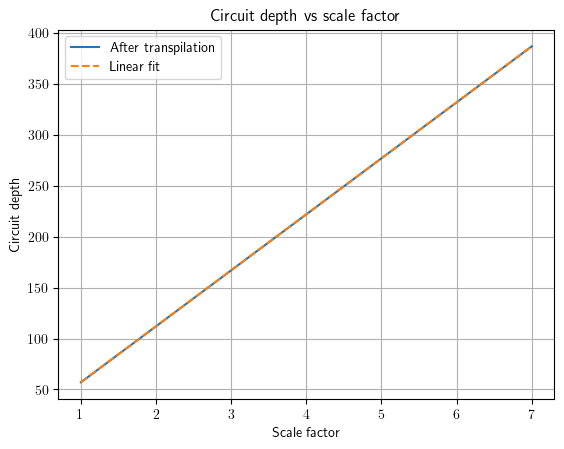

In [76]:
plt.plot(scale_factors,np.array(circ_depth_sca),label='After transpilation')
plt.plot(scale_factors,popt[0]*np.array(scale_factors)+popt[1],linestyle='--',label='Linear fit')
plt.title('Circuit depth vs scale factor')
plt.xlabel('Scale factor')
plt.ylabel('Circuit depth')
plt.legend()
plt.grid()
plt.show()

<h2>Helper functions:</h2>

In [30]:
def return_counts_scaled(job_id,p,sf,shots):
    counts = None
    job = provider.backend.retrieve_job(job_id.strip())
    if not job.done():
        print(job_id.strip()+' is not complete') # to avoid silent fail
        return counts
    results = job.result()
    counts = results.get_counts()
    res = np.zeros(shape=(4,p,sf)) #(type,prob,scale_factor)
    for j in range(sf):
        for i in range(p):
            probs_f = np.zeros(2**2)
            for k in range(2**2):
                cnt = counts[np.ravel_multi_index((j,i,k),(sf,p,2**2))]
                for key,val in cnt.items():
                    probs_f[int(key,2)] += val/shots
            res[:,i,j] = probs_f[:]/4
    return res

In [13]:
def mitigate(scale_factors,exp_vals,extrapolation_method):
    mit_val = None
    if extrapolation_method == 'richardson':
        return inference.RichardsonFactory.extrapolate(scale_factors,exp_vals)
    elif extrapolation_method == 'poly2':
        return inference.PolyFactory.extrapolate(scale_factors,exp_vals,2)
    elif extrapolation_method == 'linear':
        return inference.LinearFactory.extrapolate(scale_factors,exp_vals)
    else:
        raise ValueError('Unrecogized extrapolation method')

In [14]:
def get_mitigated_vals(scale_factors,res,p,extrapolation_method):
    res_mit = np.zeros((4,p))
    for j in range(p):
        for i in range(2**2):
            res_mit[i,j] = mitigate(scale_factors,res[i,j,:],extrapolation_method)
    return res_mit

In [42]:
def calc_pump_sim(pump,sys,env,p,repcnt):
    
    simulator = cirq.Simulator()
    final_hist = Counter()
    
    for j in range(2**2):
        circuit = cirq.Circuit()
        if (j&1) == 1:
            circuit.append(cirq.X.on(sys[0]))
        if (j&2) == 2:
            circuit.append(cirq.X.on(sys[1]))
        circuit.append(pump(sys,env,p))
        circuit.append(cirq.measure(sys, key = 'answer'))
        
        result = simulator.run(circuit,repetitions=repcnt)
        histogram = result.histogram(key = 'answer')
        final_hist += histogram

    for x in final_hist:
        final_hist[x]/=(4*repcnt)

    return final_hist

def calc_plot(hists):
    pops = [[],[],[],[]]
    for counts in hists:
        for i in range(4):
            pops[i].append(counts[i])
    return pops

sim_probs = np.linspace(0,1,num=20)
hists = [calc_pump_sim(zz_xx_pump,sys,env,p,20000) for p in sim_probs]
hists_marker = [calc_pump_sim(zz_xx_pump,sys,env,p,20000) for p in probs]
pops = calc_plot(hists)
pops_marker = calc_plot(hists_marker)

<h2>Running job:</h2>

In [77]:
with open('./Jobs/MRE/8.txt','x') as job_id_file:
        job = backend.run(circ_list,shots=repcnt)   #Run job
        job_id_file.write(job.job_id()+'\n')    #Write to file
        print('Submitted job with job id '+job.job_id())

print('All complete.')

Submitted job with job id cntmac9ye0eg008ayyyg
All complete.


In [118]:
job_id = 'cntmac9ye0eg008ayyyg'
res = return_counts_scaled(job_id,probs.shape[0],len(scale_factors),repcnt)

In [119]:
res_mit_poly2 = get_mitigated_vals(scale_factors,res,probs.shape[0],'poly2')
res_mit_richardson = get_mitigated_vals(scale_factors,res,probs.shape[0],'richardson')
res_mit_linear = get_mitigated_vals(scale_factors,res,probs.shape[0],'linear')
res_unmit = res[...,0]

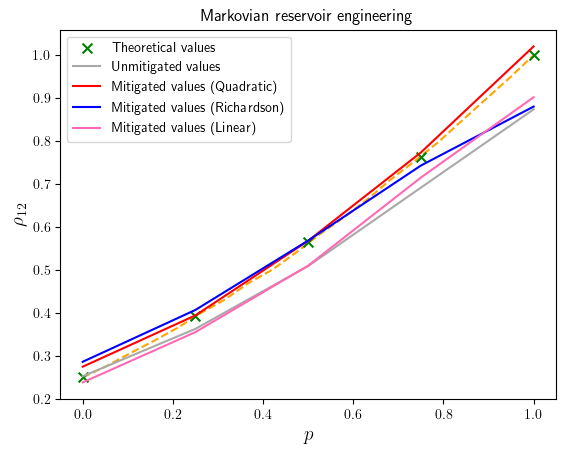

In [123]:
kind = 3
plt.rcParams['text.usetex'] = True
plt.plot(sim_probs,pops[kind],linestyle='--',c='orange',zorder=0)
plt.scatter(probs,pops_marker[kind],s=50,label='Theoretical values',marker='x',c='green',zorder=1)
plt.plot(probs,res_unmit[kind],label='Unmitigated values',c='darkgrey',zorder=2)
plt.plot(probs,res_mit_poly2[kind],label='Mitigated values (Quadratic)',c='red',zorder=3)
plt.plot(probs,res_mit_richardson[kind],label='Mitigated values (Richardson)',c='blue',zorder=3)
plt.plot(probs,res_mit_linear[kind],label='Mitigated values (Linear)',c='hotpink',zorder=3)
plt.xlabel(r'$p$',fontsize=14)
plt.ylabel(r'$\rho_{12}$',fontsize=14)
plt.title(r'Markovian reservoir engineering')
plt.legend()
plt.show()

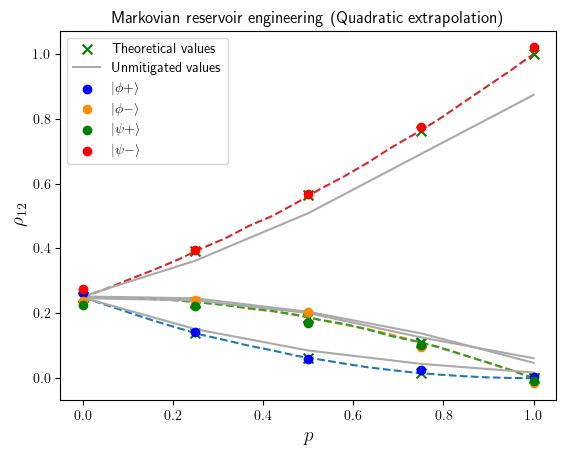

In [124]:
res_plot = res_mit_poly2

plt.plot(sim_probs,pops[0],linestyle='--')
plt.plot(sim_probs,pops[1],linestyle='--')
plt.plot(sim_probs,pops[2],linestyle='--')
plt.plot(sim_probs,pops[3],linestyle='--')

plt.scatter(probs,pops_marker[0],s=50,label='Theoretical values',marker='x',c='green',zorder=1)
plt.scatter(probs,pops_marker[1],s=50,marker='x',c='green',zorder=1)
plt.scatter(probs,pops_marker[2],s=50,marker='x',c='green',zorder=1)
plt.scatter(probs,pops_marker[3],s=50,marker='x',c='green',zorder=1)

plt.plot(probs,res_unmit[0,:],label='Unmitigated values',c='darkgrey',zorder=2)
plt.plot(probs,res_unmit[1,:],c='darkgrey',zorder=2)
plt.plot(probs,res_unmit[2,:],c='darkgrey',zorder=2)
plt.plot(probs,res_unmit[3,:],c='darkgrey',zorder=2)

plt.scatter(probs,res_plot[0,:],label=r'$\vert \phi+ \rangle$',c='blue',zorder=3)
plt.scatter(probs,res_plot[1,:],label=r'$\vert \phi- \rangle$',c='darkorange',zorder=3)
plt.scatter(probs,res_plot[2,:],label=r'$\vert \psi+ \rangle$',c='green',zorder=3)
plt.scatter(probs,res_plot[3,:],label=r'$\vert \psi- \rangle$',c='red',zorder=3)

plt.xlabel(r'$p$',fontsize=14)
plt.ylabel(r'$\rho_{12}$',fontsize=14)
plt.title(r'Markovian reservoir engineering (Quadratic extrapolation)')
plt.legend()
plt.show()